Import Dependencies

#1 Install and import dependencies

In [2]:
import numpy as np
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import sys
import cv2

#2 Get Data and Create a custom class

In [3]:
class MRI(Dataset):
    def __init__(self):
        healthy = []
        path = "/home/biddy/Desktop/t_MRI/brain_tumor_dataset/no/*.jpg"
        paths = "/home/biddy/Desktop/t_MRI/brain_tumor_dataset/no/*.JPG"
        for image in glob.iglob(path):
            img =cv2.imread(image)
            img =cv2.resize(img,(128,128))
            b,g,r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape(img.shape[2],img.shape[0],img.shape[1])
            healthy.append(img)
        for i in glob.iglob(paths):
            img = cv2.imread(i)
            img = cv2.resize(img,(128,128))
            b,g,r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape(img.shape[2],img.shape[0],img.shape[1])
            healthy.append(img)

        tumor = []
        path ="/home/biddy/Desktop/t_MRI/brain_tumor_dataset/yes/*.jpg"
        paths ="/home/biddy/Desktop/t_MRI/brain_tumor_dataset/yes/*.JPG"
        for image in glob.iglob(path):
            img = cv2.imread(image)
            img = cv2.resize(img,(128,128))
            b,g,r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape(img.shape[2],img.shape[0],img.shape[1])
            tumor.append(img)
        for i in glob.iglob(paths):
            img = cv2.imread(i)
            img = cv2.resize(img,(128,128))
            b,g,r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape(img.shape[2],img.shape[0],img.shape[1])
            tumor.append(img)

#            Our Images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)

# Our Ground lables
        tumor_label = np.ones(tumor.shape[0],dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0],dtype=np.float32)

 #concatenate
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))


    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        sample ={"image":self.images[index], "label": self.labels[index]}
        return sample

    def normalize(self):
        self.images = self.images/255.0


#3 Create CNN Model

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5)
        )

        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1)
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0),-1)
        x = self.fc_model(x)
        x = F.sigmoid(x)

        return x


#4 Evaluate a New-Born Neural Network

In [8]:
mri_dataset = MRI()
mri_dataset.normalize()
model = CNN()

#5 Train Data

In [9]:
eta = 0.001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(),lr=eta)
dataloader = DataLoader(mri_dataset, batch_size = 32, shuffle = True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [10]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D["image"]
        label = D["label"]
        y_hat = model(data)
        #define loss function
        error = nn.BCELoss()
        loss= torch.sum(error(y_hat.squeeze(),label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1)% 10==0:
        print("Train Epoch:{}loss:{:.6f}".format(epoch+1, np.mean(losses)))

Train Epoch:10loss:0.516488
Train Epoch:20loss:0.389983
Train Epoch:30loss:0.222295
Train Epoch:40loss:0.078906
Train Epoch:50loss:0.012859
Train Epoch:60loss:0.003457
Train Epoch:70loss:0.001708
Train Epoch:80loss:0.001071
Train Epoch:90loss:0.000763
Train Epoch:100loss:0.000577
Train Epoch:110loss:0.000443
Train Epoch:120loss:0.000378
Train Epoch:130loss:0.000301
Train Epoch:140loss:0.000247
Train Epoch:150loss:0.000209
Train Epoch:160loss:0.000180
Train Epoch:170loss:0.000158
Train Epoch:180loss:0.000140
Train Epoch:190loss:0.000122
Train Epoch:200loss:0.000109
Train Epoch:210loss:0.000098
Train Epoch:220loss:0.000089
Train Epoch:230loss:0.000079
Train Epoch:240loss:0.000073
Train Epoch:250loss:0.000065
Train Epoch:260loss:0.000062
Train Epoch:270loss:0.000056
Train Epoch:280loss:0.000050
Train Epoch:290loss:0.000047
Train Epoch:300loss:0.000043
Train Epoch:310loss:0.000041
Train Epoch:320loss:0.000037
Train Epoch:330loss:0.000035
Train Epoch:340loss:0.000031
Train Epoch:350loss:0.0

#6 Test Model

In [11]:
model.eval()
outputs = []
y_true = []

with torch.no_grad():
    for  D in dataloader:
        image = D["image"]
        label = D["label"]


        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

outputs = np.concatenate(outputs, axis = 0). squeeze()
y_true = np.concatenate(y_true, axis = 0).squeeze()

Define Threshold

In [12]:
def threshold(scores, threshold= 0.50, minimum = 0, maximum=1.0):
    x= np.array(list(scores))
    x[x >= threshold] = maximum
    x[x< threshold] = minimum
    return x

Check Accuracy and confusion matrix

In [13]:
accuracy_score(y_true, threshold(outputs))

1.0

Visualizing the Feature Maps of Maps of the convolutional filters

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

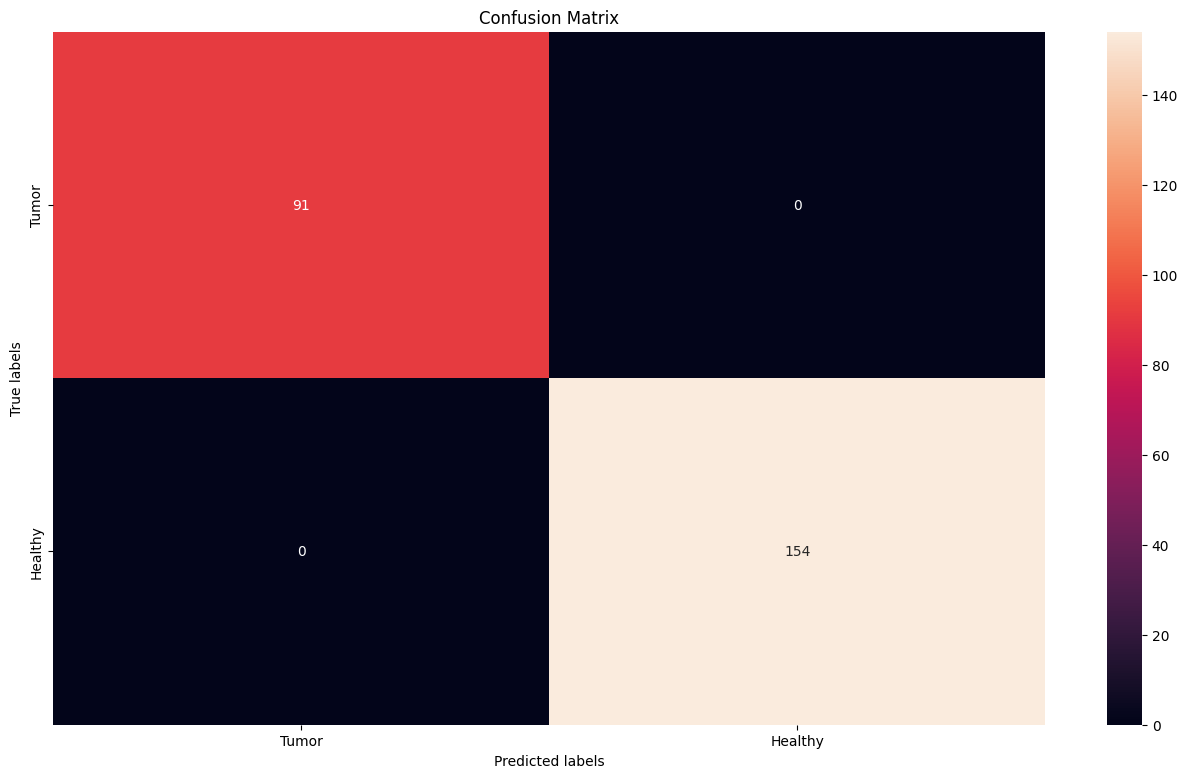

In [14]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))
ax = plt.subplot()
sns.heatmap(cm, annot= True, fmt="g", ax=ax);
#ax.set_xlabel("Predicted labels"); ax.set_ylabel("True labels");
#ax.set_title("Confusion Matrix");
#ax.axis.set_ticklabels(["Tumor", "Healthy"])
#ax.yxis.set_ticklabels(["Tumor", "Healthy"])
# Set labels and title
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")

# Set tick labels for x-axis and y-axis
ax.set_xticklabels(["Tumor", "Healthy"])
ax.set_yticklabels(["Tumor", "Healthy"])